**Classification on the MNIST Dataset Using PyTorch**

Rafael Espinosa Mena

Rafaelespinosamena@gmail.com

In [1]:
# Import required libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.utils import make_grid
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import copy

In [2]:
# Set a random seed for reproducibility
torch.manual_seed(123)
np.random.seed(123)

**Data Loading and Augmentation**

Here, we will load the data into three different sets: the training, validation and test sets split as 60%, 20% and 20% of the total data respectively. We will then augment it by stretching and compressing images to anywhere between 80-120% of their original sizes. This is meant to give the neural network more images to train on, resembling the differences in handwriting that a person can make.

In [3]:
# Transformations for data augmentation
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)), # Stretch and compress
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and split MNIST dataset
full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)



100%|██████████| 9912422/9912422 [00:00<00:00, 131663704.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104157948.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42854168.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22438785.36it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Original Images:


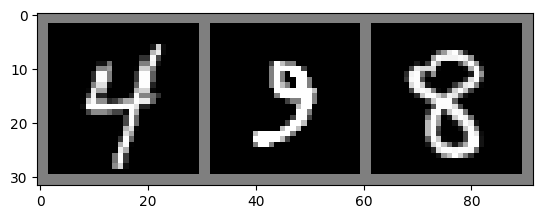

Labels:      4     9     8


In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Select random indices for displaying images
indices = np.random.choice(len(full_trainset), 3, replace=False)

# Subset for displaying original images
subset_trainset = Subset(full_trainset, indices)
subset_trainloader = DataLoader(subset_trainset, batch_size=3, shuffle=False)
dataiter = iter(subset_trainloader)
images, labels = next(dataiter)

# Show original images
print("Original Images:")
imshow(make_grid(images))
print('Labels: ', ' '.join('%5s' % labels[j].item() for j in range(3)))




Original Images (Top) and Augmented Images (Bottom):


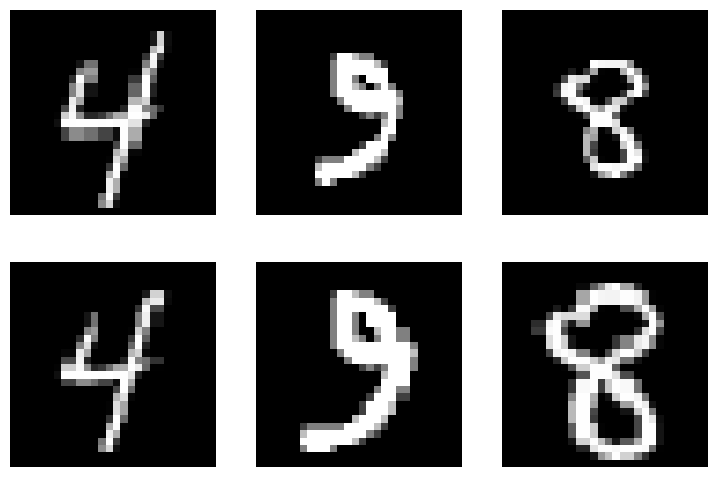

In [5]:
def imshow_side_by_side(images_orig, images_augmented):
    # Unnormalize and convert to numpy
    images_orig = images_orig / 2 + 0.5
    images_augmented = images_augmented / 2 + 0.5
    np_images_orig = images_orig.numpy()
    np_images_augmented = images_augmented.numpy()

    # Set up the subplot configuration
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    for i in range(3):
        # Display original image
        axes[0, i].imshow(np.transpose(np_images_orig[i], (1, 2, 0)), cmap='gray')
        axes[0, i].axis('off')

        # Display augmented image
        axes[1, i].imshow(np.transpose(np_images_augmented[i], (1, 2, 0)), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

# Load the original images
dataiter_original = iter(subset_trainloader)
images_original, _ = next(dataiter_original)

# Transformations with stretch and compress for displaying purposes
transform_augment_display = transforms.Compose([
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply transformations to the same subset for augmented images
augmented_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_augment_display)
subset_augmented = Subset(augmented_dataset, [subset_trainset.indices[j] for j in range(3)])
subset_augmented_loader = DataLoader(subset_augmented, batch_size=3, shuffle=False)
dataiter_augmented = iter(subset_augmented_loader)
images_augmented, _ = next(dataiter_augmented)

# Display original and augmented images side by side
print("Original Images (Top) and Augmented Images (Bottom):")
imshow_side_by_side(images_original, images_augmented)




Above we can see the original images in the first row, and then the second row are the augmented images. The augmentation is more visible in the third image, i.e. the number "8", where clearly it has been stretched to be bigger.

**Creating and Training the Neural Network**

For this, we will use a simple convolutional neural network (CNN) where the convolutional layer is meant to find the distinguishing features of each digit.

In [6]:
# Define a neural network with a convolutional layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # MNIST images are 1 channel (grayscale)
        # Fully connected layers
        self.fc1 = nn.Linear(10 * 12 * 12, 500)  # Adjusted input size after conv layer
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # Apply conv layer with ReLU and max pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 10 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [7]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

When training, we will set an early stopping mechanism. This stops the training of the CNN if the validation loss doesn't decrease for more than 3 epochs in a row. We do this to avoid overfitting which would reduce the accuracy of the model.

In [8]:
def print_training_info(headers, rows):
    table = PrettyTable()
    table.field_names = headers
    for row in rows:
        table.add_row(row)
    print(table)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
best_model = copy.deepcopy(net.state_dict())

# For storing training and validation information
training_info = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
headers = ["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]

# Training loop with validation
for epoch in range(60):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss_avg = val_loss / len(valloader)
    val_accuracy = 100 * correct_val / total_val
    training_info.append([epoch + 1, train_loss, train_accuracy, val_loss_avg, val_accuracy])
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    # Check for early stopping
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        epochs_no_improve = 0
        best_model = copy.deepcopy(net.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break

# Print training information
print_training_info(headers, training_info)

# Load the best model found before early stopping
net.load_state_dict(best_model)

Early stopping triggered after epoch 39
+-------+----------------------+-------------------+----------------------+---------------------+
| Epoch |      Train Loss      |   Train Accuracy  |   Validation Loss    | Validation Accuracy |
+-------+----------------------+-------------------+----------------------+---------------------+
|   1   |  0.9222931536833445  | 76.31458333333333 | 0.43132922869730506  |  86.88333333333334  |
|   2   |  0.3388171431322893  | 90.11666666666666 |  0.2742230051216927  |  92.05833333333334  |
|   3   | 0.23283237643539906  |      93.29375     |  0.1988571080121588  |  94.24166666666666  |
|   4   | 0.17274864913523197  | 95.08541666666666 |  0.1655890911302351  |        95.225       |
|   5   | 0.13818605186790228  | 96.03333333333333 | 0.12502828525735976  |  96.44166666666666  |
|   6   | 0.11643703092386325  | 96.70416666666667 | 0.11127051840873158  |        96.675       |
|   7   | 0.10130608060459297  | 97.06666666666666 | 0.10837501151725015  |   

<All keys matched successfully>

**Evaluating the Network's Performance**

Here we will use both a confusion matrix and classification report to analyze the network's performance for classifying the digits.

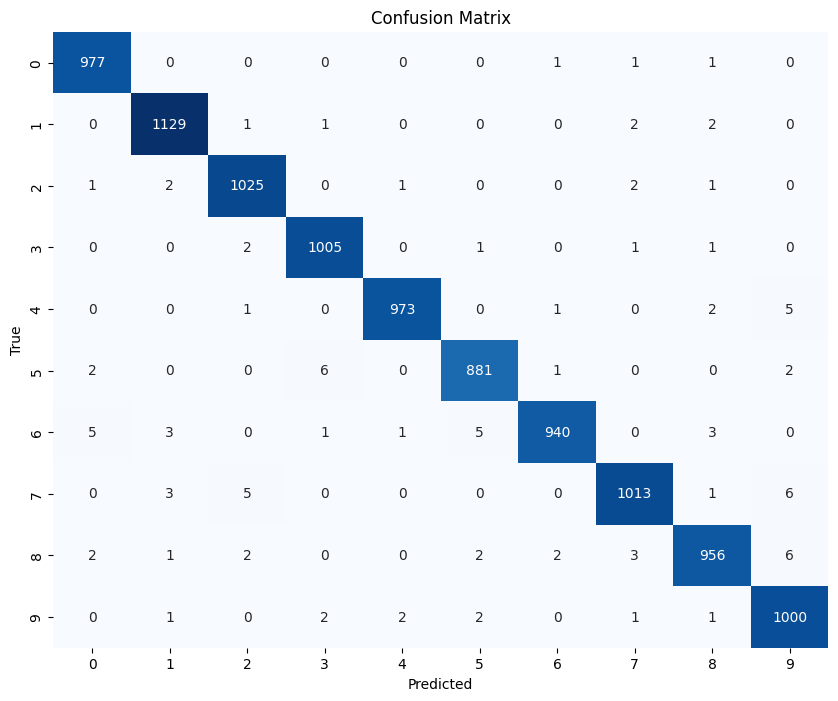


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [9]:
# Evaluate the network
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_preds.extend(predicted.tolist())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = range(10)  # Adjust this if your dataset has different classes

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report:')
print(classification_report(all_labels, all_preds))

Below, we'll plot the loss and accuracy for the training and validation data, to analyze how they imporved as the network trained.

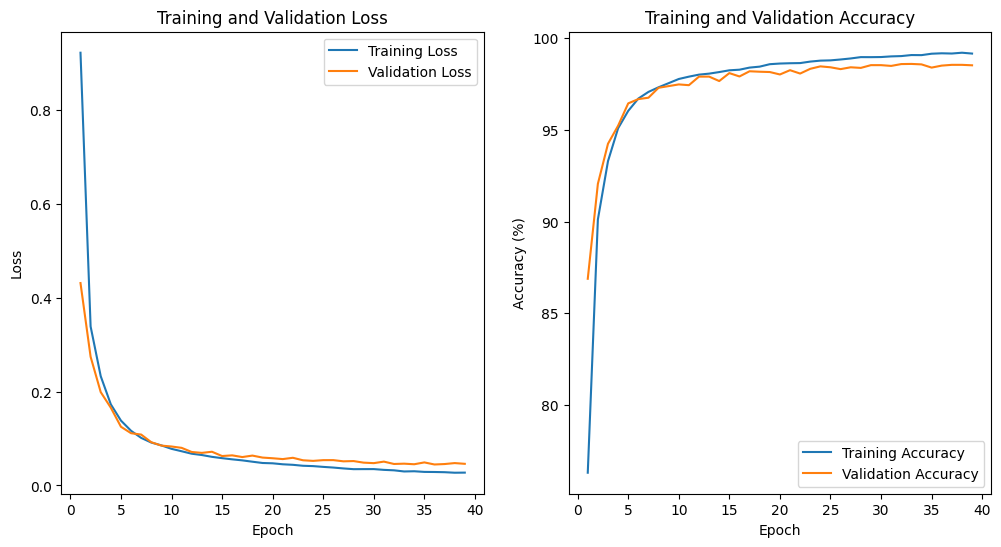

In [10]:
# Determine the actual number of epochs trained (in case of early stopping)
actual_epochs = len(train_losses)

# Create an x-axis range based on the actual number of epochs
epochs = range(1, actual_epochs + 1)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

As we can see, all the lines increase or decrease as expected, signifying that A) the CNN is well suited for the task and B) the early stopoing mechanism performed as expected and stopped training once the validation loss curve leveled out (signifying no possible increase in performance).

Below, we'll plot all the ROC Curves for the 10 different classes. A AUC (area under curve) score close to 1 signifies good performance of the network for that class.

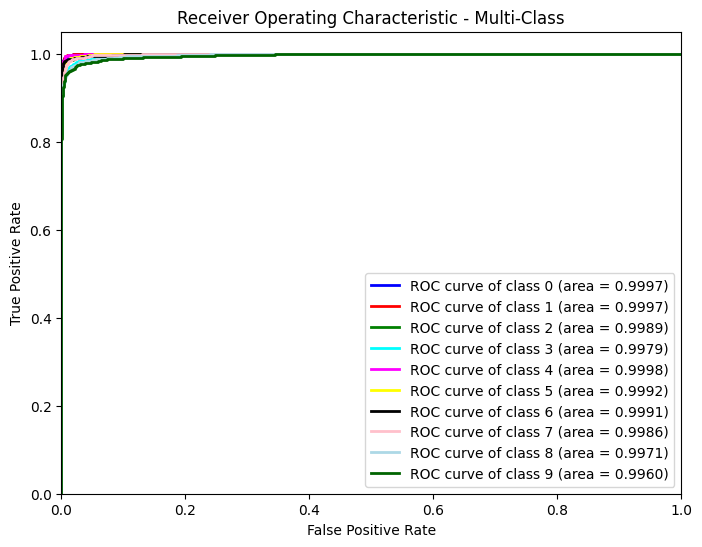

In [11]:
# Binarize the labels for all classes
n_classes = 10  # Number of classes in the MNIST dataset
y_test_binarized = label_binarize(all_labels, classes=range(n_classes))

# Apply the model to get the scores
net.eval()
all_scores = []
with torch.no_grad():
    for images, _ in testloader:
        outputs = net(images)
        all_scores.extend(outputs.cpu().numpy())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], np.array(all_scores)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightblue', 'darkgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-Class')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

From the AUC scores, we can see that the CNN is extremely good at classifying each class, since they are all above 0.996 which is very close to 1. From the accuracy report, it can also be seen that the precision scores for each class are above 99%, and this is confirmed visually from the confusion matrix where most of the points is concentrated on the diagonal, signifying a strong classification record. Therefore, this model, albeit simple, is extremely effective at classifying the MNIST dataset.